In [84]:
import dicom, cv2, re
import os, fnmatch, sys
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K


**Path for reading Dicom Images for Training**

seed is set here to get repeatability in results while tuning Network and Parameters

In [115]:
seed = 1234
np.random.seed(seed)
SUNNYBROOK_ROOT_PATH = 'SunnyBrook'

TRAIN_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,'TrainingDataContours')
TRAIN_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,'TrainingImages')
TEST_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,'TestDataContours')
TEST_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,'TestImages')


** Pre Processing **

- Crop the centre of the Image
- Input is of Rank 3 (h X w x d)
- Crop_Size is expected to be an integer

In [86]:
def center_crop(ndarray, crop_size):
    
    h, w, d = ndarray.shape
    # center crop
    h_offset = int((h - crop_size) / 2)
    w_offset = int((w - crop_size) / 2)
    cropped = ndarray[h_offset:(h_offset+crop_size),
                      w_offset:(w_offset+crop_size), :]

    return cropped

** Helper Functions to Read Data **

- Images and the corresponding contours are present in different folders
- Contours are provided in the form of polygons
- A one to one mapping is created between the Image Data and the Contour Data


In [87]:
def shrink_case(case):
    toks = case.split('-')
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return '-'.join([shrink_if_number(t) for t in toks])

      
class Contour(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path
        match = re.search(r'\\([^\\]*)\\contours-manual\\IRCCI-expert\\IM-0001-(\d{4})-.*', ctr_path)
        self.case = shrink_case(match.group(1))
        self.img_no = int(match.group(2))
    
    def __str__(self):
        return '<Contour for case %s, image %d>' % (self.case, self.img_no)
    
    __repr__ = __str__


def read_contour(contour, data_path):
    filename = 'IM-0001-%04d.dcm' % (contour.img_no)
    full_path = os.path.join(data_path, contour.case, filename)
    f = dicom.read_file(full_path)
    img = f.pixel_array.astype('int')
    mask = np.zeros_like(img, dtype='uint8')
    coords = np.loadtxt(contour.ctr_path, delimiter=' ').astype('int')
    cv2.fillPoly(mask, [coords], 1)
    if img.ndim < 3:
        img = img[..., np.newaxis]
        mask = mask[..., np.newaxis]
    
    return img, mask


def map_all_contours(contour_path, contour_type, shuffle=True):
    print(contour_path)
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files,
                        'IM-0001-*-'+contour_type+'contour-manual.txt')]
    if shuffle:
        print('Shuffling data')
        np.random.shuffle(contours)
    print('Number of examples: {:d}'.format(len(contours)))
    contours = map(Contour, contours)
    
    return contours


def export_all_contours(contours, data_path, crop_size):
    print('\nProcessing {:d} images and labels ...\n'.format(len(contours)))
    images = np.zeros((len(contours), crop_size, crop_size, 1))
    masks = np.zeros((len(contours), crop_size, crop_size, 1))
    for idx, contour in enumerate(contours):
        img, mask = read_contour(contour, data_path)
        img = center_crop(img, crop_size=crop_size)
        mask = center_crop(mask, crop_size=crop_size)
        images[idx] = img
        masks[idx] = mask
    return images, masks



** Contour Type **

- As part of Data set there are Two types of Conturs available
- type 'i' for endocardium
- type 'o' for epicardium
- As part of the Project we are interested in EndoCardium COntours

In [101]:
contour_type='i'
crop_size = 112

** Training and Validation Split **

- 10% of the Data is split to be used as Validation Data Set
- 

In [117]:
train_ctrs = map_all_contours(TRAIN_CONTOUR_PATH, contour_type, shuffle=True)
test_ctrs = map_all_contours(TEST_CONTOUR_PATH, contour_type,shuffle=True)
train_ctrs = list(train_ctrs)
split = int(0.1*len(train_ctrs))
dev_ctrs = train_ctrs[0:split]
train_ctrs = train_ctrs[split:]


print('Processing Training Data ...')
img_train, mask_train = export_all_contours(train_ctrs,
                                                TRAIN_IMG_PATH,
                                                crop_size=crop_size)
print('Processing Validation Data ...')

img_dev, mask_dev = export_all_contours(dev_ctrs,
                                            TRAIN_IMG_PATH,
                                            crop_size=crop_size)
print('Processing Test Data ...')
img_test, mask_test = export_all_contours(list(test_ctrs),
                                            TEST_IMG_PATH,
                                            crop_size=crop_size)


SunnyBrook\TrainingDataContours
Shuffling data
Number of examples: 539
SunnyBrook\TestDataContours
Shuffling data
Number of examples: 266
Processing Training Data ...

Processing 486 images and labels ...

Processing Validation Data ...

Processing 53 images and labels ...

Processing Test Data ...

Processing 266 images and labels ...



** Plot Some Training Data and Labels **

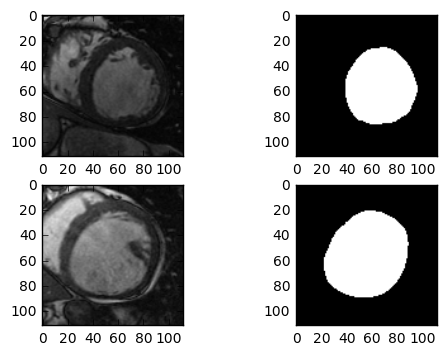

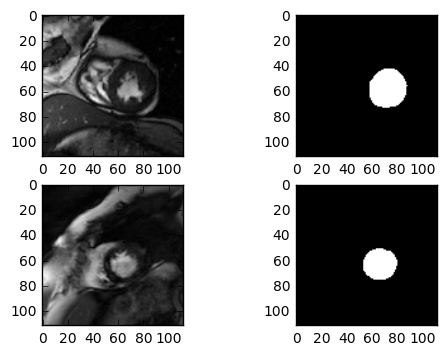

In [103]:

import matplotlib.pyplot as plt
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_dev[0,:,:,0],cmap='gray')
axarr[0,1].imshow(mask_dev[0,:,:,0],cmap='gray')
axarr[1,0].imshow(img_dev[1,:,:,0],cmap='gray')
axarr[1,1].imshow(mask_dev[1,:,:,0],cmap='gray')
plt.show()

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_dev[2,:,:,0],cmap='gray')
axarr[0,1].imshow(mask_dev[2,:,:,0],cmap='gray')
axarr[1,0].imshow(img_dev[3,:,:,0],cmap='gray')
axarr[1,1].imshow(mask_dev[3,:,:,0],cmap='gray')
plt.show()



** Import the U-Net Model **

- Data Augmentation is performed.
- 180 degree rotation , horizantal Flip and Vertical Flip 

In [104]:
from fcn_model_new import *
input_shape = (crop_size, crop_size, 1)
num_classes = 2
model = get_unet(input_shape, num_classes, weights=None)
    
kwargs = dict(
        rotation_range=180,
        zoom_range=0.0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
    )


** Data Generator **

- Data Generators are tools in Keras that provide nice interface to generate the data on demand
without occupying entire memory.

In [107]:
# Image and Mask Generator
image_datagen = ImageDataGenerator(**kwargs)
mask_datagen = ImageDataGenerator(**kwargs)

epochs = 40
mini_batch_size=1
max_iter = (len(train_ctrs) / mini_batch_size) * epochs
curr_iter = 0
base_lr = K.eval(model.optimizer.lr)

image_generator = image_datagen.flow(img_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
mask_generator = mask_datagen.flow(mask_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
train_generator = zip(image_generator, mask_generator)

image_generator_val = image_datagen.flow(img_dev, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
mask_generator_val = mask_datagen.flow(mask_dev, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
train_generator_val = zip(image_generator_val, mask_generator_val)

** Fit the Model **
- Batch_size is set to 1
- Steps per epoch is selected as the number of samples in training data.
- Validation Steps is also selected as number of samples in Validation_data.
(These are as suggested in Keras Documentation)

In [108]:
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
model.fit_generator(train_generator,steps_per_epoch=486, validation_data=train_generator_val,validation_steps=53,epochs=40,verbose=1,callbacks=[tbCallBack])

Epoch 1/40
486/486 [==============================] - 22s - loss: 0.5873 - dice_coef: 0.4074 - val_loss: 0.5697 - val_dice_coef: 0.4267
Epoch 2/40
486/486 [==============================] - 22s - loss: 0.5638 - dice_coef: 0.4306 - val_loss: 0.5544 - val_dice_coef: 0.4417
Epoch 3/40
486/486 [==============================] - 22s - loss: 0.5490 - dice_coef: 0.4459 - val_loss: 0.5223 - val_dice_coef: 0.4742
Epoch 4/40
486/486 [==============================] - 22s - loss: 0.4692 - dice_coef: 0.5263 - val_loss: 0.4288 - val_dice_coef: 0.5687
Epoch 5/40
486/486 [==============================] - 22s - loss: 0.4246 - dice_coef: 0.5717 - val_loss: 0.4148 - val_dice_coef: 0.5824
Epoch 6/40
486/486 [==============================] - 22s - loss: 0.3771 - dice_coef: 0.6193 - val_loss: 0.3649 - val_dice_coef: 0.6335
Epoch 7/40
486/486 [==============================] - 22s - loss: 0.3095 - dice_coef: 0.6877 - val_loss: 0.3211 - val_dice_coef: 0.6774
Epoch 8/40
486/486 [============================

** Plot Some of the Predicted outputs **

In [109]:
import matplotlib.pyplot as plt
predMasks = model.predict(img_dev,verbose=1)


53/53 [==============================] - 2s     


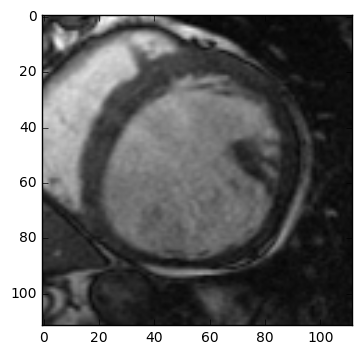

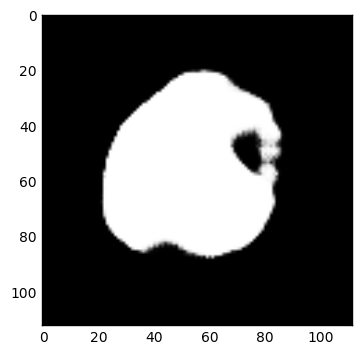

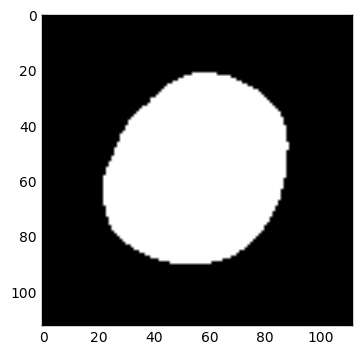

In [112]:
img_num =1
plt.imshow(img_dev[img_num,:,:,0],cmap='gray')

plt.show()
plt.imshow(predMasks[img_num,:,:,0],cmap='gray')
plt.show()
plt.imshow(mask_dev[img_num,:,:,0],cmap='gray')
plt.show()

** Observation **

- Predicted Mask above nicely segments the Left Ventricle 
- The Left ventricle semented by the model appears more accurate than the labeled data


In [120]:
loss,dice_coef_test = model.evaluate(img_test,mask_test,verbose=1)
print('\nTesting loss: {}, dice_coeff : {}\n'.format(loss, dice_coef_test))

266/266 [==============================] - 1s     

Testing loss: 0.1202956245357829, dice_coeff : 0.8782727897615361



** Test Results **

- Dice_coeff on the testing data set is 0.878 
- It is very close to 0.91 acheived by the Feature based segmentation using Conditonal Random Field